# RAGAS Customization
1. 합성 데이터별 시나리오 출력
2. MultihopAbstractQuery 최적화
   * 병렬처리
   * 노드별 이웃 노드 맵 생성
3. 합성 데이터셋 번역 기능
4. 합성 데이터셋 reference_contexts의 index_id 추적

In [1]:
import os
import json
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('../data/document/역도/chunk_with_overlap.json', 'r', encoding='utf-8') as f:
    origin_data = json.load(f)


total_data = []
for data in origin_data:
    total_data.extend(data)

print(len(total_data))

255


## 지식 그래프 생성

In [3]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType

generator_llm = LangchainLLMWrapper(ChatOpenAI(model='gpt-4o-mini'))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

c:\Users\dbtmd\anaconda3\envs\SportAgent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_core.documents import Document

kg = KnowledgeGraph()

for doc in total_data:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={'page_content': doc['page_content'],
                        'document_metadata': doc['metadata']}
        )
    )

## 정보 추출 및 관계 형성

In [5]:
from ragas.testset.transforms import apply_transforms
from ragas.testset.transforms.extractors.embeddings import EmbeddingExtractor
from ragas.testset.transforms.extractors.llm_based import (
    SummaryExtractor,
    ThemesExtractor,
    NERExtractor
)
ner_extractor = NERExtractor(llm=generator_llm)
summary_extractor = SummaryExtractor(llm=generator_llm)
themes_extractor = ThemesExtractor(llm=generator_llm)
embedding_extractor = EmbeddingExtractor(
    embedding_model=generator_embeddings,
    property_name="summary_embedding",
    embed_property_name="summary",
    filter_nodes=lambda node: node.get_property("summary") is not None
)

transforms = [
    ner_extractor,
    summary_extractor,
    themes_extractor,
    embedding_extractor
]

# apply_transforms(kg, transforms)

In [6]:
from ragas.testset.transforms.relationship_builders import (
    CosineSimilarityBuilder,
    OverlapScoreBuilder,
)

cosine_sim_builder = CosineSimilarityBuilder(
    property_name="summary_embedding",
    new_property_name="summary_similarity",
    threshold=0.7
)

relation_builder = OverlapScoreBuilder(
    property_name="entities",
    new_property_name="overlap_score",
    threshold=0.01,
    distance_threshold=0.9,
)

transforms = [cosine_sim_builder, relation_builder]
# apply_transforms(kg, transforms)

In [7]:
# kg.save('../data/document/역도/kg.json')
kg = KnowledgeGraph.load('../data/document/역도/kg.json')

## knowledge graph 분석 

### knowledge graph의 nodes 분석
* 분석항목
  * 전체 문서 내 최빈 entity
  * 각 단원(sector)별 최빈 entity
  * 각 단원별 비검출 node 수
* 현황 분석
  * NERExtractor 특징
    * NERExtractor는 일반 entity가 아닌 named entity를 추출함
    * named entity는 고유명사로 특정 이름을 가진 개체로, 주로 사람, 장소, 조직, 날짜/시간 등을 대상으로 함
  * 시사점
    * 비검출 관련
      * 전체 255개의 node 중 40.4%의 노드에서 entity 비검출
      * 예상 사용자들의 답변 관련 최다 이용될 것으로 예상하는 두 단원(2, 5단원)의 비검출 비율이 약 50%
    * 검출 엔티티 관련
      * 최빈 상위 10개 entity 분석 결과, '바벨', '역도', '무릎', '역도선수', '심리기술훈련' 등 사용자 예상 질문과 관성이 적은 entity가 주로 추출
      * 섹터별 상위 entity 분포 결과, 문서 전체에 분포하는 entity가 부재

In [129]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def analyze_node_entity(kg):
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 데이터 구조 초기화
    sector_null = {}
    sector_total = {}
    sector_entities = {}
    total_entities = []
    sectors_order = []
    total_node_count = len(kg.nodes)
    null_node_count = 0

    # 데이터 수집
    for node in kg.nodes:
        sector = node.properties['document_metadata']['heading']['heading1']
        entities = node.properties.get('entities', [])
        if sector not in sectors_order:
            sectors_order.append(sector)
        if sector not in sector_null:
            sector_null[sector] = 0
            sector_total[sector] = 0
            sector_entities[sector] = []
        sector_total[sector] += 1
        if not entities:
            sector_null[sector] += 1
            null_node_count += 1
        else:
            sector_entities[sector].extend(entities)
            total_entities.extend(entities)

    # 전체 entity 없는 노드 비율 계산
    null_ratio = null_node_count / total_node_count * 100

    # 섹터별 entity 없는 노드 비율 계산
    sector_null_ratio = {sector: sector_null[sector] / sector_total[sector] * 100 for sector in sectors_order}

    # 전체 상위 10개 entity
    total_entity_counts = Counter(total_entities)
    top_total_entities = dict(sorted(total_entity_counts.items(), key=lambda x: x[1], reverse=True)[:10])

    # 섹터별 상위 5개 entity
    sector_top_entities = {}
    for sector in sectors_order:
        counts = Counter(sector_entities[sector])
        sector_top_entities[sector] = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5])

    # 시각화
    plt.figure(figsize=(15, 10))

    # 1. 섹터별 entity 없는 노드 비율 막대그래프
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(sector_null_ratio.keys(), sector_null_ratio.values(), color='skyblue')
    plt.ylabel('비율(%)')
    plt.title(f'섹터별 Entity 없는 노드 비율\n(전체 노드 중 entity 없는 노드 비율: {null_ratio:.1f}%)')
    plt.xticks(rotation=45, ha='right')
    # 막대 위에 값 표시
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height:.1f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3pt 위에
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. 전체 상위 10개 entity 막대 그래프
    plt.subplot(2, 2, 2)
    bars2 = plt.bar(top_total_entities.keys(), top_total_entities.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('전체 상위 10개 Entity')
    # 막대 위에 값 표시
    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 3. 섹터별 상위 entity 히트맵 (깔끔하게)
    plt.subplot(2, 1, 2)
    sectors = list(sector_top_entities.keys())
    all_entities = sorted({e for ents in sector_top_entities.values() for e in ents})
    heatmap_data = np.zeros((len(sectors), len(all_entities)))
    for i, sector in enumerate(sectors):
        for j, entity in enumerate(all_entities):
            heatmap_data[i, j] = sector_top_entities[sector].get(entity, 0)

    im = plt.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')

    # 컬러바
    cbar = plt.colorbar(im, label='출현 빈도')
    cbar.ax.tick_params(labelsize=10)

    # x, y축 라벨
    plt.xticks(range(len(all_entities)), all_entities, rotation=45, ha='right', fontsize=10)
    plt.yticks(range(len(sectors)), sectors, fontsize=10)
    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('Sector', fontsize=12)
    plt.title('섹터별 상위 Entity 분포', fontsize=14, pad=15)

    # value annotation (0이 아닌 값만)
    for i in range(len(sectors)):
        for j in range(len(all_entities)):
            value = int(heatmap_data[i, j])
            if value > 0:
                plt.text(j, i, str(value), ha='center', va='center', color='black', fontsize=9, fontweight='bold')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 비율 텍스트로도 출력
    print(f"전체 노드 수: {total_node_count}")
    print(f"Entity가 없는 노드 수: {null_node_count}")
    print(f"전체 노드 중 entity가 없는 노드 비율: {null_ratio:.1f}%")

    return {
        'sector_null_counts': sector_null,
        'sector_null_ratio': sector_null_ratio,
        'top_total_entities': top_total_entities,
        'sector_top_entities': sector_top_entities,
        'null_node_ratio': null_ratio
    }

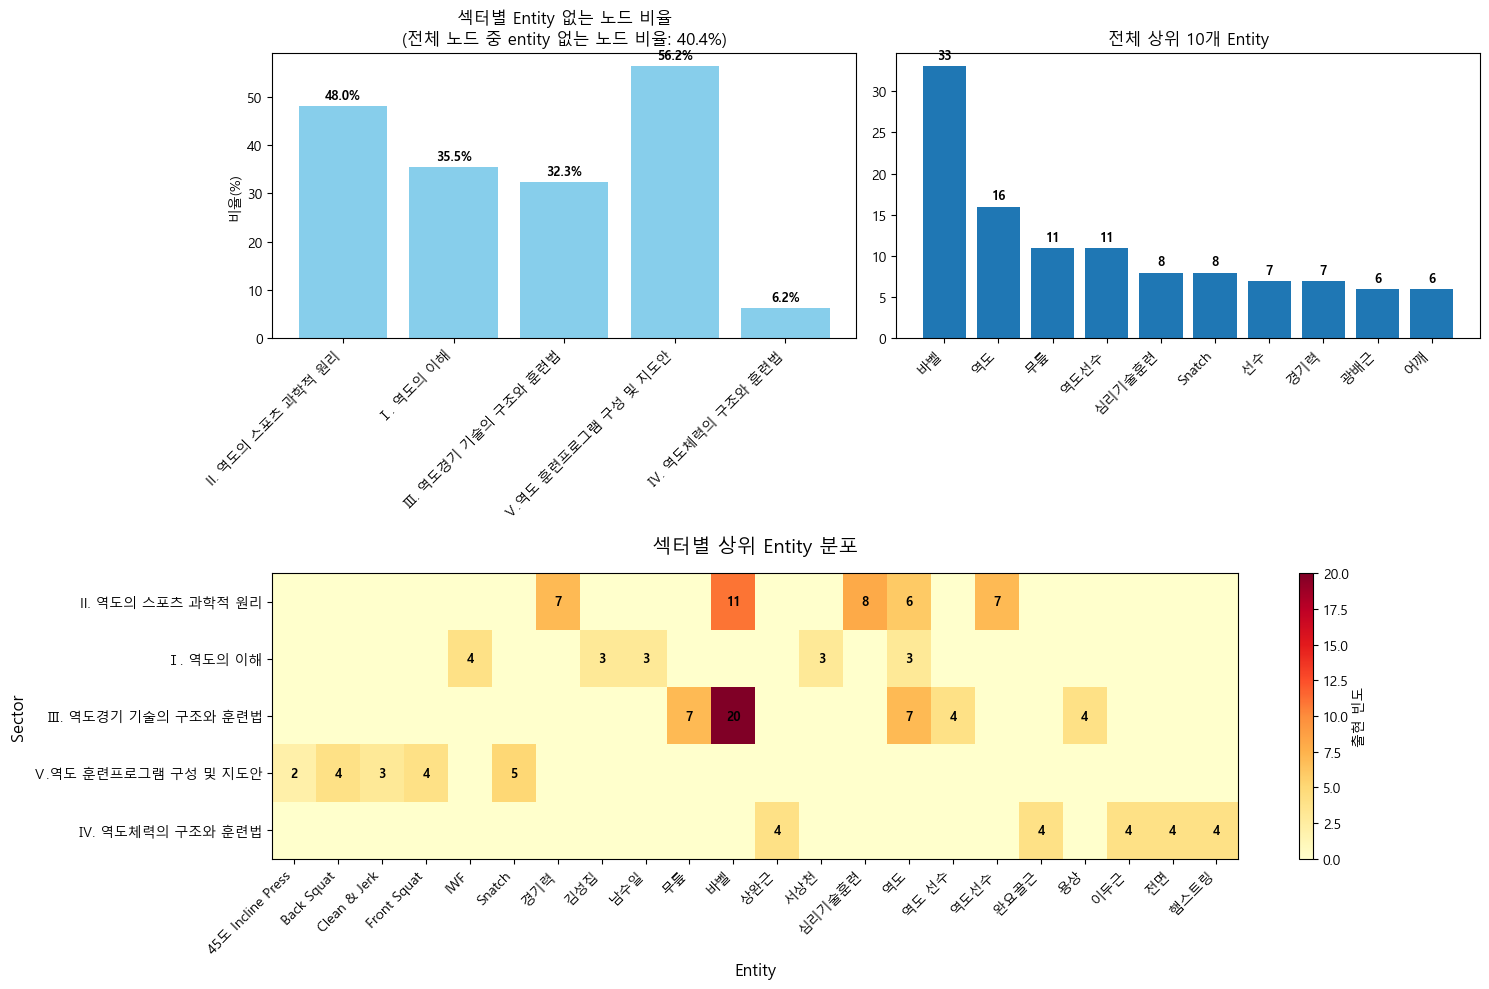

전체 노드 수: 255
Entity가 없는 노드 수: 103
전체 노드 중 entity가 없는 노드 비율: 40.4%


In [130]:
analyzed_result = analyze_node_entity(kg)

### knowledge graph의 relationships 분석
* defualt_transforms의 relationship 형성 과정
  * OverlapScoreBuilder relationship
    * OverlapScoreBuilder 기반의 relationship은 MultiHopSpecificQuerySynthesizer에서 활용됨
    * find_tow_nodes_single_rel 메서드에서 사용
    * 두 노드의 공통된 entity 정도에 따라 relationship 형성 유무 결정
  * Cosine_Similarity relationship
    * Cosine_Similarity 기반의 relationship은 MultiHopAbstractQuerySynthesizer에서 활용됨
    * find_indirect_clusters 메서드에서 사용
    * 두 노드의 summary embedding의 cosine similarity에 따라 relationship 형성 유무 결정
* default_transforms의 결과, 타 section 과의 relationship 정도 분석
  * OverrlapScoreBuilder relationship
    * overlap relationship의 경우 동일 섹션 관계가 전체 중 62.8%를 차지
  * Cosine_Similarity relationship
    * Cosine_Similarity relationship의 경우 66.6%의 타 섹션 관계를 차지함
    * section간 연결 비율 분석 결과, 역도경기 기술의 구조와 훈련법 섹션이 타 섹션과의 연결 밀도가 낮음
* 시사점
  * overlap relationship은 연결 수 자체도 매우 적으며, 타 섹션과의 비율도 낮음
  * cosine relationship은 타 섹션과의 비율은 높으나, 요약의 유사성에 대한 내용으로 한계가 존재.
  * 질문 빈도가 높을 것으로 예상되는, 특정 entity 관련 주제의 다양성 context가 필요한 질문 생성에 적합하지 않음

In [161]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def analyze_relationship(kg):
    # 노드 id → 섹션명 매핑
    node_sector = {}
    for node in kg.nodes:
        node_id = node.id.hex
        sector = node.properties['document_metadata']['heading']['heading1']
        node_sector[node_id] = sector

    # 통계 변수 초기화
    rel_types = ['entities_overlap', 'cosine_similarity']
    stats = {rtype: {'total': 0, 'same_sector': 0, 'diff_sector': 0} for rtype in rel_types}
    sector_rel_count = defaultdict(int)  # 섹션별 관계 수

    # 관계 순회하며 통계 집계
    for rel in kg.relationships:
        rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
        source_id = rel.__dict__['source'].id.hex
        target_id = rel.__dict__['target'].id.hex
        source_sector = node_sector.get(source_id, 'Unknown')
        target_sector = node_sector.get(target_id, 'Unknown')

        # sector별 관계 수 (source, target 모두 카운트)
        sector_rel_count[source_sector] += 1
        sector_rel_count[target_sector] += 1

        if rel_type not in stats:
            continue

        stats[rel_type]['total'] += 1
        if source_sector == target_sector:
            stats[rel_type]['same_sector'] += 1
        else:
            stats[rel_type]['diff_sector'] += 1

    # 1. OverlapScoreBuilder 그래프
    plt.figure(figsize=(7, 5))
    overlap_same = stats['entities_overlap']['same_sector']
    overlap_diff = stats['entities_overlap']['diff_sector']
    overlap_total = stats['entities_overlap']['total']
    plt.bar(['동일 섹션', '타 섹션'], [overlap_same, overlap_diff], color=['#4F81BD', '#C0504D'])
    for i, v in enumerate([overlap_same, overlap_diff]):
        plt.text(i, v, f'{v} ({v/overlap_total*100:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.title('OverlapScoreBuilder 관계 분포', fontsize=14)
    plt.ylabel('관계 개수')
    plt.tight_layout()
    plt.show()

    # 2. CosineSimilarity 그래프
    plt.figure(figsize=(7, 5))
    cosine_same = stats['cosine_similarity']['same_sector']
    cosine_diff = stats['cosine_similarity']['diff_sector']
    cosine_total = stats['cosine_similarity']['total']
    plt.bar(['동일 섹션', '타 섹션'], [cosine_same, cosine_diff], color=['#4F81BD', '#C0504D'])
    for i, v in enumerate([cosine_same, cosine_diff]):
        plt.text(i, v, f'{v} ({v/cosine_total*100:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.title('CosineSimilarity 관계 분포', fontsize=14)
    plt.ylabel('관계 개수')
    plt.tight_layout()
    plt.show()

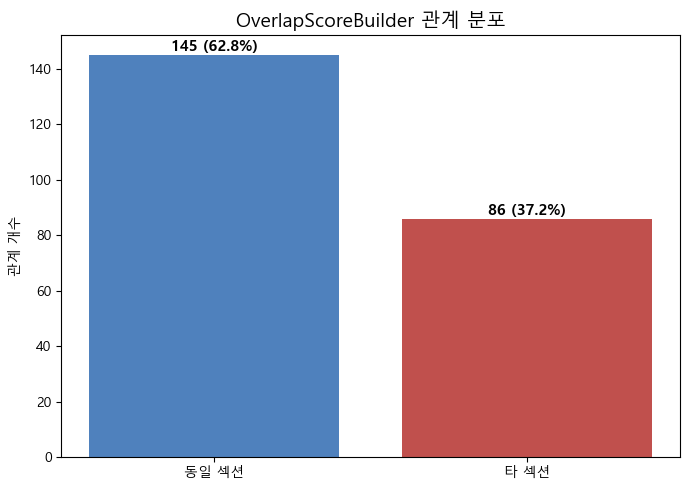

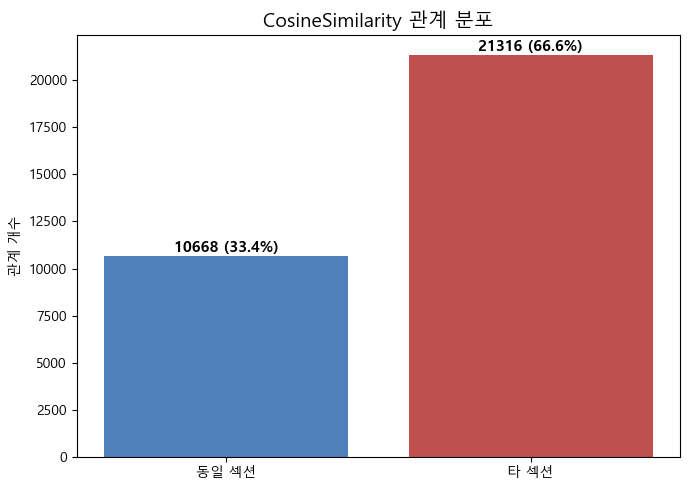

In [162]:
analyze_relationship(kg)

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_sector_connection_ratio(kg):
    # 노드 id → 섹터명 매핑 및 섹터별 노드 id 집합
    node_sector = {}
    sector_nodes = defaultdict(set)
    for node in kg.nodes:
        node_id = node.id.hex
        sector = node.properties['document_metadata']['heading']['heading1']
        node_sector[node_id] = sector
        sector_nodes[sector].add(node_id)

    sectors = sorted(sector_nodes.keys())
    n = len(sectors)

    # 실제 관계 수 매트릭스 (source_sector, target_sector)
    actual_matrix = np.zeros((n, n), dtype=int)
    # 가능한 최대 관계 수 매트릭스
    max_matrix = np.zeros((n, n), dtype=int)

    # cosine_similarity 관계만 집계
    for rel in kg.relationships:
        rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
        if rel_type != 'cosine_similarity':
            continue
        source_id = rel.__dict__['source'].id.hex
        target_id = rel.__dict__['target'].id.hex
        source_sector = node_sector.get(source_id, 'Unknown')
        target_sector = node_sector.get(target_id, 'Unknown')
        if source_sector in sectors and target_sector in sectors:
            i = sectors.index(source_sector)
            j = sectors.index(target_sector)
            actual_matrix[i, j] += 1

    # 가능한 최대 관계 수 계산
    for i, s1 in enumerate(sectors):
        for j, s2 in enumerate(sectors):
            max_matrix[i, j] = len(sector_nodes[s1]) * len(sector_nodes[s2])

    # 연결 비율(%) 매트릭스
    ratio_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if max_matrix[i, j] > 0:
                ratio_matrix[i, j] = actual_matrix[i, j] / max_matrix[i, j] * 100

    # DataFrame으로 보기 좋게
    ratio_df = pd.DataFrame(ratio_matrix, index=sectors, columns=sectors)

    # 히트맵 시각화
    plt.figure(figsize=(8, 6))
    im = plt.imshow(ratio_matrix, cmap='YlOrRd', vmin=0, vmax=100)
    plt.colorbar(im, label='연결 비율(%)')
    plt.xticks(range(n), sectors, rotation=45, ha='right')
    plt.yticks(range(n), sectors)
    plt.title('section 간 연결 비율(%) - cosine_similarity 관계만')
    # 값 표시
    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{ratio_matrix[i, j]:.1f}%", ha='center', va='center',
                     color='black' if ratio_matrix[i, j] < 60 else 'white', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return ratio_df

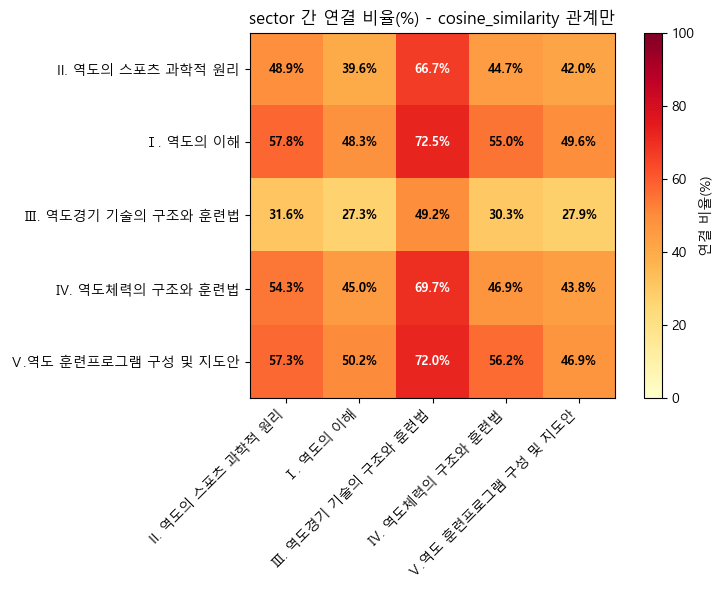

In [166]:
ratio_df = analyze_sector_connection_ratio(kg)

### SingleHopSpecificQuery, MultiHopSpecificQuery 시나리오 출력

In [46]:
from typing import Dict, List, Tuple, Union, Set, Any
from dataclasses import dataclass, field
import typing as t
import logging
import uuid
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
from ragas.testset.graph import KnowledgeGraph, Node

from ragas.testset.synthesizers.multi_hop import MultiHopScenario, MultiHopQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.abstract import MultiHopAbstractQuerySynthesizer
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.specific import MultiHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.single_hop import SingleHopScenario, SingleHopQuerySynthesizer

class ScenarioIDManager:
    """시나리오 ID를 관리하는 클래스"""
    def __init__(self):
        self._scenario_id_map: Dict[int, str] = {}
    
    def get_scenario_id(self, scenario: Union[SingleHopScenario, MultiHopScenario]) -> str:
        """시나리오의 ID를 반환하거나 새로 생성"""
        scenario_hash = id(scenario)
        if scenario_hash not in self._scenario_id_map:
            self._scenario_id_map[scenario_hash] = str(uuid.uuid4())
        return self._scenario_id_map[scenario_hash]
    
    def clear(self):
        """모든 시나리오 ID 매핑을 초기화"""
        self._scenario_id_map.clear()

@dataclass
class CustomSingleHopSpecificSynthesizer(SingleHopSpecificQuerySynthesizer):
    name: str = "custom_single_hop_specific_synthesizer"
    _scenario_cache: Dict = field(default_factory=dict)
    generated_scenarios: List[SingleHopScenario] = field(default_factory=list, init=False)
    id_manager: ScenarioIDManager = field(default_factory=ScenarioIDManager)

    async def _generate_scenarios(
        self,
        n: int,
        knowledge_graph: KnowledgeGraph,
        persona_list: List,
        callbacks,
    ) -> List[SingleHopScenario]:
        scenarios = await super()._generate_scenarios(n, knowledge_graph, persona_list, callbacks)
        self.generated_scenarios.extend(scenarios)
        return scenarios
    
    def get_all_scenario_details(self):
        details = []
        for scenario in self.generated_scenarios:
            detail = {
                "scenario_id": self.id_manager.get_scenario_id(scenario),
                "term": scenario.term,
                "persona": {
                    "name": scenario.persona.name,
                    "description": scenario.persona.role_description
                },
                "query_style": scenario.style.name,
                "query_length": scenario.length.name
            }
            details.append(detail)
        return details

@dataclass
class CustomMultiHopSpecificSynthesizer(MultiHopSpecificQuerySynthesizer):
    name: str = "custom_multi_hop_specific_synthesizer"
    _scenario_cache: Dict = field(default_factory=dict)
    generated_scenarios: List[MultiHopScenario] = field(default_factory=list, init=False)
    id_manager: ScenarioIDManager = field(default_factory=ScenarioIDManager)

    async def _generate_scenarios(
        self,
        n: int,
        knowledge_graph: KnowledgeGraph,
        persona_list: List,
        callbacks,
    ) -> List[MultiHopScenario]:
        scenarios = await super()._generate_scenarios(n, knowledge_graph, persona_list, callbacks)
        self.generated_scenarios.extend(scenarios)
        return scenarios

    def get_all_scenario_details(self):
        details = []
        for scenario in self.generated_scenarios:
            detail = {
                "scenario_id": self.id_manager.get_scenario_id(scenario),
                "combinations": scenario.combinations,
                "persona": {
                    "name": scenario.persona.name,
                    "description": scenario.persona.role_description
                },
                "query_style": scenario.style.name,
                "query_length": scenario.length.name
            }
            details.append(detail)
        return details

### MultiHopAbstractQuerySunthesizer 최적화 및 시나리오 출력

In [47]:
logger = logging.getLogger(__name__)

@dataclass
class FastMultiHopAbstractQuerySynthesizer(MultiHopAbstractQuerySynthesizer):
    name: str = "fast_multi_hop_abstract_synthesizer"
    _scenario_cache: Dict = field(default_factory=dict)
    generated_scenarios: List[MultiHopScenario] = field(default_factory=list)
    id_manager: ScenarioIDManager = field(default_factory=ScenarioIDManager)

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._neighbor_cache = {}
        self._cluster_cache = {}
        self.generated_scenarios = []
        
    def _build_neighbor_map(self, knowledge_graph: KnowledgeGraph) -> dict:
        """선처리: 노드별 이웃 노드 맵 생성"""
        if not self._neighbor_cache:
            neighbor_map = defaultdict(set)
            # 한 번의 순회로 모든 관계 처리
            for rel in knowledge_graph.relationships:
                if rel.get_property("summary_similarity"):
                    neighbor_map[rel.source].add(rel.target)
            self._neighbor_cache = dict(neighbor_map)
        return self._neighbor_cache

    def _find_cluster_from_node(self, start_node: Node, neighbor_map: dict, max_depth: int = 2) -> set:
        """단일 노드에서 시작하는 클러스터 찾기"""
        # 캐시 확인
        cache_key = (start_node.id, max_depth)
        if cache_key in self._cluster_cache:
            return self._cluster_cache[cache_key]

        visited = {start_node}
        current_level = {start_node}
        
        # BFS 사용 (더 효율적인 메모리 사용)
        for depth in range(max_depth):
            next_level = set()
            for node in current_level:
                neighbors = neighbor_map.get(node, set())
                next_level.update(n for n in neighbors if n not in visited)
            visited.update(next_level)
            current_level = next_level
            if not current_level:  # 더 이상 확장할 노드가 없으면 중단
                break

        # 결과 캐싱
        self._cluster_cache[cache_key] = visited
        return visited

    def get_node_clusters(self, knowledge_graph: KnowledgeGraph) -> t.List[t.Set[Node]]:
        """최적화된 클러스터 찾기"""
        # 1. 이웃 노드 맵 구축 (캐시 활용)
        neighbor_map = self._build_neighbor_map(knowledge_graph)
        
        # 2. 병렬 처리를 위한 함수
        def process_node_chunk(nodes):
            return [self._find_cluster_from_node(node, neighbor_map) for node in nodes]

        # 3. 노드를 청크로 분할하여 병렬 처리
        chunk_size = max(1, len(knowledge_graph.nodes) // (4 * 2))  # CPU 코어 수의 2배 정도의 청크
        node_chunks = [
            list(knowledge_graph.nodes)[i:i + chunk_size]
            for i in range(0, len(knowledge_graph.nodes), chunk_size)
        ]

        # 4. 병렬 처리 실행
        all_clusters = []
        with ThreadPoolExecutor(max_workers=4) as executor:
            chunk_results = list(executor.map(process_node_chunk, node_chunks))
            for chunk_result in chunk_results:
                all_clusters.extend(chunk_result)

        # 5. 중복 제거 및 최소 크기 필터링 (set 연산 사용)
        unique_clusters = set()
        min_cluster_size = 2  # 최소 클러스터 크기 설정
        
        for cluster in all_clusters:
            if len(cluster) >= min_cluster_size:
                frozen_cluster = frozenset(cluster)
                unique_clusters.add(frozen_cluster)

        logger.info(f"Found {len(unique_clusters)} unique clusters")
        return [set(cluster) for cluster in unique_clusters]

    async def _generate_scenarios(
        self,
        n: int,
        knowledge_graph: KnowledgeGraph,
        persona_list: List,
        callbacks,
    ) -> List[MultiHopScenario]:
        scenarios = await super()._generate_scenarios(n, knowledge_graph, persona_list, callbacks)
        self.generated_scenarios.extend(scenarios)
        return scenarios

    def get_all_scenario_details(self):
        details = []
        for scenario in self.generated_scenarios:
            detail = {
                "scenario_id": self.id_manager.get_scenario_id(scenario),
                "combinations": scenario.combinations,
                "persona": {
                    "name": scenario.persona.name,
                    "description": scenario.persona.role_description
                },
                "query_style": scenario.style.name,
                "query_length": scenario.length.name
            }
            details.append(detail)
        return details

In [66]:
from typing import Optional, List, Dict, Any, Tuple, Union
from dataclasses import dataclass, field
from ragas.testset.synthesizers.generate import TestsetGenerator
from ragas.testset.synthesizers.testset_schema import Testset, TestsetSample
from ragas.testset.synthesizers.base import BaseScenario
import random
import pandas as pd
from tqdm import tqdm
import uuid

from langchain.callbacks import StdOutCallbackHandler
from ragas.testset.persona import generate_personas_from_kg
from ragas.testset.synthesizers.utils import calculate_split_values
from ragas.executor import Executor

class ScenarioManager:
    """시나리오 정보를 관리하는 클래스"""
    def __init__(self):
        self.scenario_details = {
            "single_hop": [],
            "multi_hop": [],
            "fast_multi_hop": []
        }
        
    def add_scenario_detail(self, synthesizer_type: str, detail: Dict):
        """시나리오 상세 정보 추가"""
        if synthesizer_type in self.scenario_details:
            self.scenario_details[synthesizer_type].append(detail)
            
    def get_all_scenario_details(self):
        """모든 시나리오 상세 정보 반환"""
        return self.scenario_details

class CustomTestGenerator(TestsetGenerator):
    """TestGenerator를 상속받아 각 데이터 행별 시나리오 정보를 포함하는 커스텀 생성기"""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scenario_manager = ScenarioManager()
        
    def generate_with_details(
        self,
        testset_size: int,
        query_distribution: Optional[List[tuple]] = None,
        batch_size: Optional[int] = None,
        callbacks: Optional[List] = None,
    ) -> Tuple[pd.DataFrame, Dict[str, List[Dict]]]:
        """시나리오 상세 정보를 포함하여 데이터셋 생성"""
        all_datasets = []
        all_scenario_details = {
            "single_hop": [],
            "multi_hop": [],
            "fast_multi_hop": []
        }
        
        for i in range(0, testset_size, batch_size):
            current_batch_size = min(batch_size, testset_size - i)
            
            dataset, scenario_details = self._generate_batch(
                batch_size=current_batch_size,
                query_distribution=query_distribution,
            )
            
            all_datasets.append(dataset)
            for key in all_scenario_details:
                all_scenario_details[key].extend(scenario_details[key])
        
        # 데이터셋 병합
        merged_dataset = pd.concat(all_datasets, ignore_index=True)
        
        return merged_dataset, all_scenario_details

    def _generate_batch(
        self,
        batch_size: int,
        query_distribution: Optional[List[tuple]] = None,
        callbacks: Optional[List] = None,
    ) -> Tuple[pd.DataFrame, Dict[str, List[Dict]]]:
        """단일 배치의 데이터셋 생성"""
        # 데이터셋 생성
        dataset = self.generate(
            testset_size=batch_size,
            query_distribution=query_distribution,
            callbacks=callbacks
        )
        
        # TestsetSample을 DataFrame으로 변환
        samples_data = []
        for sample in dataset.samples:
            sample_dict = {
                "user_input": sample.user_input,
                "reference": sample.reference,
                "reference_contexts": sample.reference_contexts,
                "scenario_id": sample.scenario_id,
                "synthesizer_name": sample.synthesizer_name,
                "scenario_info": sample.scenario_info
            }
            samples_data.append(sample_dict)
            
        df = pd.DataFrame(samples_data)
        
        # 시나리오 상세 정보 반환
        scenario_details = self.scenario_manager.get_all_scenario_details()
        
        return df, scenario_details

    def generate(
        self,
        testset_size: int,
        query_distribution: Optional[List[tuple]] = None,
        num_personas: int = 3,
        run_config: Optional[Dict[str, Any]] = None,
        batch_size: Optional[int] = None,
        callbacks: Optional[List] = None,
        token_usage_parser: Optional[Any] = None,
        with_debugging_logs: bool = False,
        raise_exceptions: bool = True,
    ) -> Testset:
        """기존 generate 메소드를 오버라이드하여 시나리오 정보를 포함하도록 수정"""
        
        if run_config is not None:
            self.llm.set_run_config(run_config)

        query_distribution = query_distribution or self.default_query_distribution()
        callbacks = callbacks or []

        # 페르소나 생성
        if self.persona_list is None:
            self.persona_list = generate_personas_from_kg(
                llm=self.llm,
                kg=self.knowledge_graph,
                num_personas=num_personas,
                callbacks=callbacks,
            )
        else:
            random.shuffle(self.persona_list)

        # 시나리오 생성
        splits, _ = calculate_split_values(
            [prob for _, prob in query_distribution], testset_size
        )
        exec = Executor(
            desc="Generating Scenarios",
            raise_exceptions=raise_exceptions,
            run_config=run_config,
            keep_progress_bar=False,
            batch_size=batch_size,
        )
        
        for i, (synthesizer, _) in enumerate(query_distribution):
            exec.submit(
                synthesizer.generate_scenarios,
                n=splits[i],
                knowledge_graph=self.knowledge_graph,
                persona_list=self.persona_list[:num_personas],
                callbacks=callbacks,
            )

        scenario_sample_list = exec.results()

        # 샘플 생성
        exec = Executor(
            "Generating Samples",
            raise_exceptions=raise_exceptions,
            run_config=run_config,
            keep_progress_bar=True,
            batch_size=batch_size,
        )
        
        additional_testset_info = []

        for i, (synthesizer, _) in enumerate(query_distribution):
            for scenario in scenario_sample_list[i]:
                # 시나리오 ID 생성
                scenario_id = str(uuid.uuid4())
                
                # 시나리오 정보 수집
                scenario_info = {}
                if hasattr(scenario, 'term'):
                    scenario_info['term'] = scenario.term
                if hasattr(scenario, 'combinations'):
                    scenario_info['combinations'] = scenario.combinations
                
                scenario_info.update({
                    'persona': {
                        'name': scenario.persona.name,
                        'description': scenario.persona.role_description
                    },
                    'query_style': scenario.style.name,
                    'query_length': scenario.length.name
                })
                
                # 시나리오 타입 결정
                if 'single_hop' in synthesizer.name.lower():
                    scenario_type = 'single_hop'
                elif 'multi_hop' in synthesizer.name.lower():
                    scenario_type = 'multi_hop'
                elif 'fast_multi_hop' in synthesizer.name.lower():
                    scenario_type = 'fast_multi_hop'
                else:
                    scenario_type = 'unknown'
                
                # 시나리오 상세 정보 저장
                self.scenario_manager.add_scenario_detail(
                    scenario_type,
                    {
                        'scenario_id': scenario_id,
                        'info': scenario_info
                    }
                )
                
                # 샘플 생성을 위한 정보 저장
                additional_testset_info.append({
                    'scenario_id': scenario_id,
                    'synthesizer_name': synthesizer.name,
                    'scenario_info': scenario_info
                })
                
                # 샘플 생성 작업 제출 (knowledge_graph 매개변수 제거)
                exec.submit(
                    synthesizer.generate_sample,
                    scenario=scenario,
                    callbacks=callbacks,
                )

        eval_samples = exec.results()

        # TestsetSample 생성
        testsets = []
        for sample, additional_info in zip(eval_samples, additional_testset_info):
            # 기본 샘플 생성
            base_sample = TestsetSample(
                user_input=sample.user_input,
                reference=sample.reference,
                reference_contexts=sample.reference_contexts,
                synthesizer_name=additional_info["synthesizer_name"],
                scenario_id=additional_info["scenario_id"],
                scenario_info=additional_info["scenario_info"]
            )
            
            # 최종 샘플 생성
            enhanced_sample = TestsetSample(
                eval_sample=base_sample,
                user_input=sample.user_input,
                reference=sample.reference,
                reference_contexts=sample.reference_contexts,
                synthesizer_name=additional_info["synthesizer_name"],
                scenario_id=additional_info["scenario_id"],
                scenario_info=additional_info["scenario_info"]
            )
            testsets.append(enhanced_sample)

        return Testset(samples=testsets)

In [67]:
import asyncio
import json
import pandas as pd
from typing import Dict, List, Tuple, Union
from dataclasses import dataclass, field
from tqdm import tqdm
from langchain.callbacks import StdOutCallbackHandler

def run_generation(generator_llm, generator_embeddings, kg):
    # CustomTestsetGenerator 인스턴스 생성
    generator = CustomTestGenerator(
        llm=generator_llm,
        embedding_model=generator_embeddings,
        knowledge_graph=kg,
        # output_dir="my_dataset" # 필요에 따라 출력 디렉토리 지정
    )

    # Synthesizer 설정
    query_distribution = [
        (CustomSingleHopSpecificSynthesizer(llm=generator_llm), 0.5),
        (CustomMultiHopSpecificSynthesizer(llm=generator_llm), 0.25),
        (FastMultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25)

    ]
    
    # 콜백 설정 (선택 사항)
    callbacks = [StdOutCallbackHandler()]
    
    # 데이터셋 생성
    merged_dataset = generator.generate_with_details(
        testset_size=10,
        query_distribution=query_distribution,
        batch_size=5
        # callbacks=callbacks, # 콜백 전달
    )

    return merged_dataset
            

In [68]:
merged_dataset = run_generation(generator_llm, generator_embeddings, kg)

Generating Samples: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


ValidationError: 1 validation error for TestsetSample
eval_sample
  Field required [type=missing, input_value={'user_input': 'What is t...query_length': 'SHORT'}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [ ]:
merged_dataset

In [193]:
merged_dataset

,user_input,reference_contexts,reference,synthesizer_name,scenario_type,combinations,term,persona_name,persona_description,query_style,query_length
0,손가락에 대해 어떤 규정이 있나요?,"[3) 벨트의 최대 넓이는 12cm를 넘지 말아야 한다. 4) 붕대, 반창고 혹은 ...","손가락에는 반창고 혹은 석고를 감을 수 있으며, 손바닥을 보호하기 위해 특수 장갑(...",custom_single_hop_specific_synthesizer,single_hop,,손가락,Strength Training Coach,Guides athletes in optimizing their lifting te...,MISSPELLED,SHORT
1,What is the significance of the 60cm distance ...,"[인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, s...",The 60cm distance refers to the length of the ...,custom_single_hop_specific_synthesizer,single_hop,,60cm,Sports Psychologist,Specializes in enhancing athletes' mental skil...,WEB_SEARCH_LIKE,SHORT
2,초급자 훈련 프로그램의 주요 목표는 무엇인가요?,"[초급자는 일주일에 3번 훈련하는 것이 바람직하며, 기록의 향상보다는 기술의 완\n...","초급자는 일주일에 3번 훈련하는 것이 바람직하며, 기록의 향상보다는 기술의 완성에 ...",custom_single_hop_specific_synthesizer,single_hop,,초급자,Strength Training Coach,Guides athletes in optimizing their lifting te...,MISSPELLED,LONG
3,How does the application of goal setting as a ...,"[<1-hop>\n\n시합에서 발생하는 심리적, 전술적 위기를 막기 위해 심리적 위...",The application of goal setting as a psycholog...,custom_multi_hop_specific_synthesizer,single_hop,,정강이,Strength Training Coach,Guides athletes in optimizing their lifting te...,WEB_SEARCH_LIKE,LONG
4,What was the significance of 김성집's participati...,[<1-hop>\n\n인상(snatch)과 용상(clean and jerk)에서 발...,김성집's participation in the 1947 세계역도선수권대회 was ...,custom_multi_hop_specific_synthesizer,single_hop,,150kg,Sports Historian,Researches and documents the history of sports...,POOR_GRAMMAR,LONG
5,What are the key nutritional requirements for ...,[<1-hop>\n\n선수들은 바벨을 머리 위로 들어 올린 상태에서 두 발을 앞뒤로...,Weightlifters require a balanced diet consisti...,multi_hop_abstract_query_synthesizer,single_hop,,초급자,Sports Historian,Researches and documents the history of sports...,WEB_SEARCH_LIKE,LONG
6,바벨 잡는 방법과 발의 균형은 어떻게 연결되나요?,"[<1-hop>\n\n바벨을 잡는 방법에는 크게 오버그립(over grip), 언더...","바벨 잡는 방법은 오버그립, 언더그립, 리버스그립, 훅그립 등 여러 가지가 있으며,...",multi_hop_abstract_query_synthesizer,multi_hop,"[목표설정, 목표설정]",,Sports Historian,Researches and documents the history of sports...,PERFECT_GRAMMAR,MEDIUM
7,What are the guidelines for using bandages on ...,"[3) 벨트의 최대 넓이는 12cm를 넘지 말아야 한다. 4) 붕대, 반창고 혹은 ...","During strength training, bandages can be appl...",custom_single_hop_specific_synthesizer,multi_hop,"[김성집, 김성집]",,Sports Psychologist,Specializes in enhancing athletes' mental skil...,PERFECT_GRAMMAR,LONG
8,150kg의 바벨을 들어올리기 위해 필요한 회전력은 얼마인가요?,"[인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, s...",150kg의 바벨을 지면으로부터 들어올리기 위해서는 약 883Nm의 회전력이 필요하...,custom_single_hop_specific_synthesizer,multi_hop,"[목표설정, 목표설정]",,Sports Psychologist,Specializes in enhancing athletes' mental skil...,POOR_GRAMMAR,LONG
9,What training regimen is recommended for 초급자 i...,"[초급자는 일주일에 3번 훈련하는 것이 바람직하며, 기록의 향상보다는 기술의 완\n...","초급자는 일주일에 3번 훈련하는 것이 바람직하며, 기록의 향상보다는 기술의 완성에 ...",custom_single_hop_specific_synthesizer,multi_hop,"[전삼각근, 삼각근]",,Strength Training Coach,Guides athletes in optimizing their lifting te...,PERFECT_GRAMMAR,LONG


## 번역

In [190]:
import re
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """
    You are an expert translator specializing in English to Korean translation.

    Translate the following English text into natural Korean.  
    Only output the translated Korean text.  
    If a term is a proper noun or a commonly used English term (e.g., "clean and jerk"), transliterate it into Korean and include the original English in parentheses.

    Text:  
    {input_text}
""" 


llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
prompt = PromptTemplate.from_template(template)
chain = prompt | llm | StrOutputParser()

In [191]:
def classify_language(text):
    english_count = len(re.findall(r'[a-zA-Z]', text))
    korean_count = len(re.findall(r'[가-힣]', text))

    if english_count >= korean_count:
        return 'english'

    return 'korean'

In [192]:
testset_df['language_user_input'] = testset_df['user_input'].apply(lambda x : classify_language(x))
testset_df['language_reference'] = testset_df['reference'].apply(lambda x : classify_language(x))

user_data = testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'].tolist()
reference_data = testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'].tolist()

translate_user = chain.batch(user_data, config={'max_concurrency': 5})
translate_reference = chain.batch(reference_data, config={'max_concurrency': 5})

NameError: name 'testset_df' is not defined

In [1]:
testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'] = translate_user
testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'] = translate_reference

NameError: name 'translate_user' is not defined

In [35]:
testset_df.iloc[:, :4].to_csv('../data/document/역도/df_sector3_4.csv', index=False)

In [36]:
testset_df.head(2)

,user_input,reference_contexts,reference,synthesizer_name,language_user_input,language_reference
0,역도에서 스내치(snatch) 기술의 기본 원리는 무엇인가요?,"[역도경기의 기술이라 함은, 경기자가 극한의 중량을 가진 바벨을 들어올리기 위\n하...",역도에서 스내치(snatch) 기술의 기본 원리는 최소한의 노력으로 최대 중량을 들...,single_hop_specifc_query_synthesizer,english,english
1,오버그립의 정의는 무엇인가요?,"[바벨을 잡는 방법에는 크게 오버그립(over grip), 언더그립(under gr...",오버그립(over grip)은 손바닥을 몸 쪽으로 향하여 위에서 바벨을 잡는 방법입니다.,single_hop_specifc_query_synthesizer,korean,korean


### 합성 데이터의 reference_contexts의 chunk_id 출력

In [75]:
import re 

def make_chunk_dict(knowledge_graph):
    chunk_dict = {}
    for node in kg.nodes:
        chunk_id = node.properties['document_metadata']['chunk_id']
        page_content = node.properties['page_content']

        chunk_dict[page_content] = chunk_id
    return chunk_dict

def regular_expression(reference_contexts, chunk_dict):
    if len(reference_contexts) == 1:
        return [chunk_dict[reference_contexts[0]]]
    else:
        return [chunk_dict[re.sub(r"<\d+-hop>\n\n", "", text)] for text in reference_contexts] 

In [76]:
def make_reference_contexts(knowledge_graph, merged_dataset):
    chunk_dict = make_chunk_dict(knowledge_graph)
    merged_dataset['reference_contexts_id'] = merged_dataset['reference_contexts'].apply(lambda x : regular_expression(x, chunk_dict))

    return merged_dataset

In [77]:
merged_dataset = make_reference_contexts(kg, merged_dataset)

# RAGAS 실험
### 평가 항목
1. Generation 
   1. Faithfulness
      * 주어진 문맥에 대한 생성된 답변의 사실적 일관성 측정
      * 답변과 검색된 문맥(retrieved context)를 기준으로 계산
      * (0, 1) 범위 스케일이며, 값이 높을수록 좋음
      * 생성된 답변이 신뢰할 수 있다고(faithful) 간구되려면 답변에서 제시된 모든 주장이 주어진 문맥(given context)에서 추론될 수 있어야 함
      * 생성된 답변에서 주장의 집합(claims)를 식별 -> 각 주장마다 주어진 맥락 기반 여부 확인
      * 점수: context 기반의 답변 내 주장 수 / 전체 주장 수
      * 예시
        * 아이슈타인의 출생일자와 출생지는 어디인가?
          * 답변 1: 아이슈타인은 독엘에서 1879/3/14에 태어났습니다.
            * 
          * 답변 2: 아이슈타인은 독엘에서 1879/4/14에 태어났습니다.
            * 
          * context: 
* 
   1. 
1. Retriever
   1. 